Load dataset

In [16]:
import pandas as pd

data_path = 'Walmart.csv'
walmart_data = pd.read_csv(data_path)
print(walmart_data)

      Store        Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0         1  05-02-2010    1643690.90             0        42.31       2.572   
1         1  12-02-2010    1641957.44             1        38.51       2.548   
2         1  19-02-2010    1611968.17             0        39.93       2.514   
3         1  26-02-2010    1409727.59             0        46.63       2.561   
4         1  05-03-2010    1554806.68             0        46.50       2.625   
...     ...         ...           ...           ...          ...         ...   
6430     45  28-09-2012     713173.95             0        64.88       3.997   
6431     45  05-10-2012     733455.07             0        64.89       3.985   
6432     45  12-10-2012     734464.36             0        54.47       4.000   
6433     45  19-10-2012     718125.53             0        56.47       3.969   
6434     45  26-10-2012     760281.43             0        58.85       3.882   

             CPI  Unemployment  
0     

First we only analyze the first store

In [17]:
store_data = walmart_data[walmart_data['Store']==1]

store_data.loc[:, 'Date'] = pd.to_datetime(store_data['Date'], format='%d-%m-%Y')
store_data = store_data.copy()
store_data['Date'] = pd.to_datetime(store_data['Date'], format='%d-%m-%Y')
store_data.set_index('Date', inplace=True)

# Separate train and test data
split_point = int(len(store_data) * 0.8)  # 80% for training, 20% for testing
train_data = store_data.iloc[:split_point]
test_data = store_data.iloc[split_point:]

print(store_data)
print(train_data)

            Store  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
Date                                                                     
2010-02-05      1    1643690.90             0        42.31       2.572   
2010-02-12      1    1641957.44             1        38.51       2.548   
2010-02-19      1    1611968.17             0        39.93       2.514   
2010-02-26      1    1409727.59             0        46.63       2.561   
2010-03-05      1    1554806.68             0        46.50       2.625   
...           ...           ...           ...          ...         ...   
2012-09-28      1    1437059.26             0        76.08       3.666   
2012-10-05      1    1670785.97             0        68.55       3.617   
2012-10-12      1    1573072.81             0        62.99       3.601   
2012-10-19      1    1508068.77             0        67.97       3.594   
2012-10-26      1    1493659.74             0        69.16       3.506   

                   CPI  Unemployment 

We plot the Weekly Sales to visualize its behaviour and perform statistical decomposition

(array([14610., 14700., 14791., 14883., 14975., 15065., 15156., 15248.,
        15340., 15431.]),
 [Text(14610.0, 0, '2010-01'),
  Text(14700.0, 0, '2010-04'),
  Text(14791.0, 0, '2010-07'),
  Text(14883.0, 0, '2010-10'),
  Text(14975.0, 0, '2011-01'),
  Text(15065.0, 0, '2011-04'),
  Text(15156.0, 0, '2011-07'),
  Text(15248.0, 0, '2011-10'),
  Text(15340.0, 0, '2012-01'),
  Text(15431.0, 0, '2012-04')])

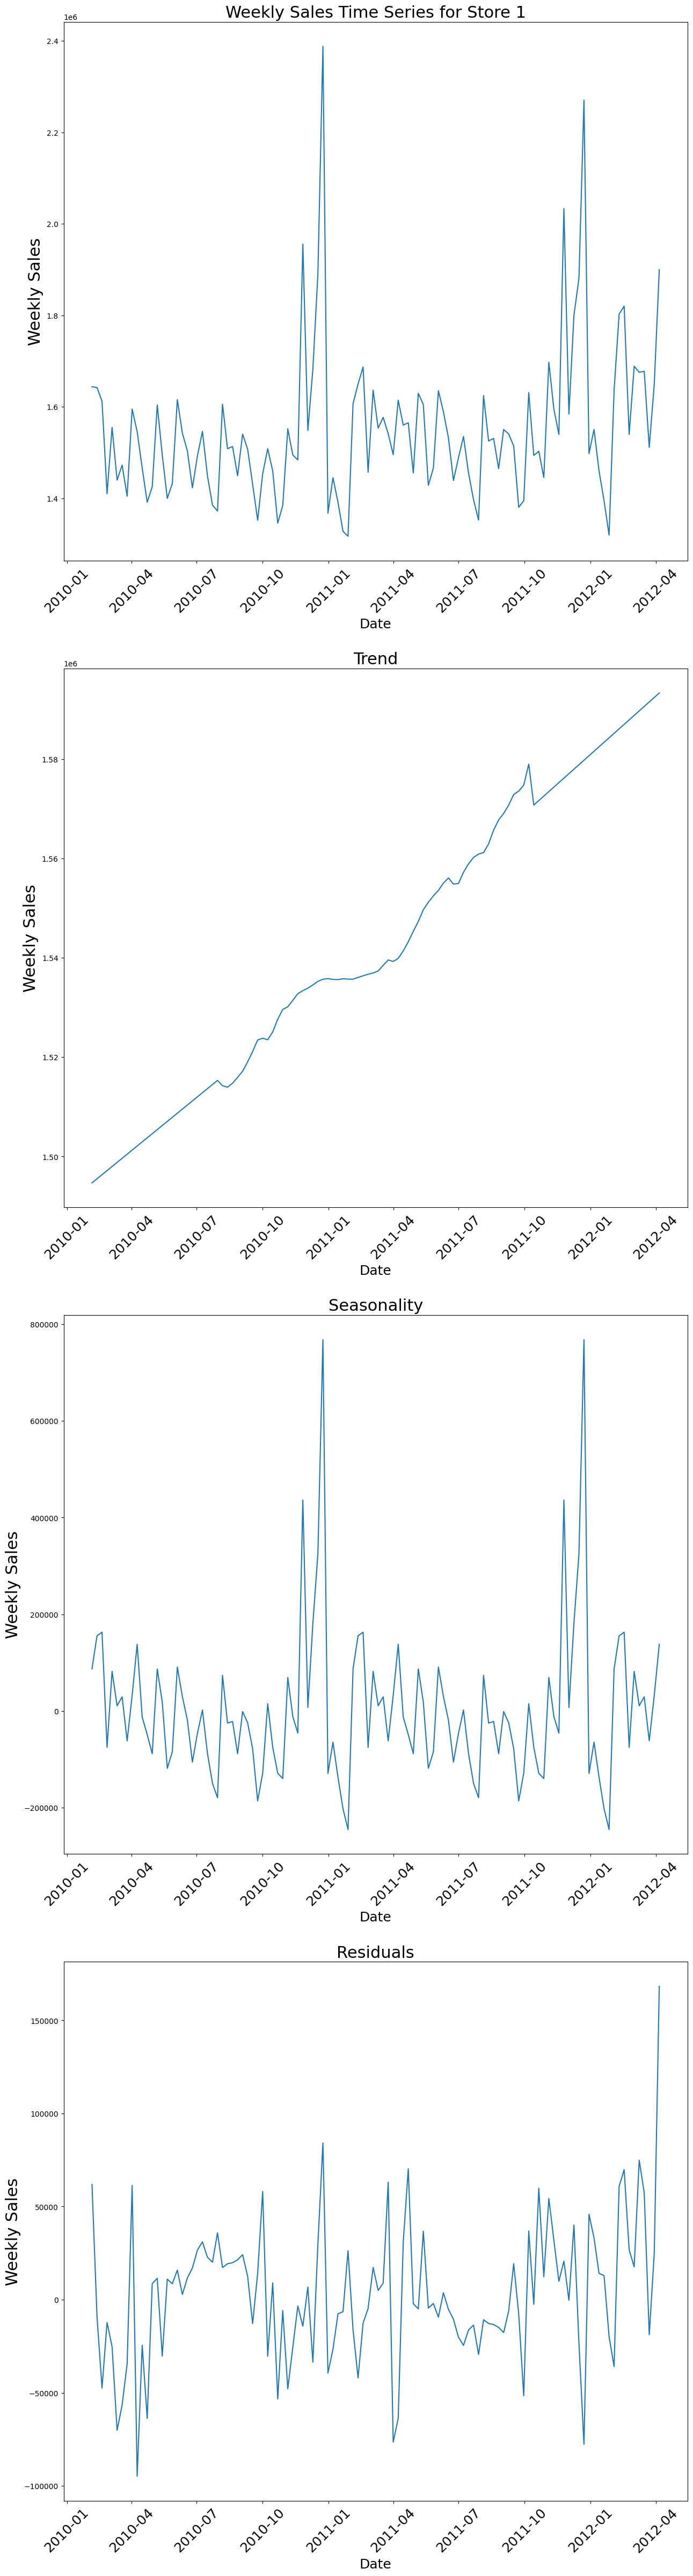

In [18]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series into trend, seasonality, and residual
decomposition = seasonal_decompose(train_data['Weekly_Sales'], extrapolate_trend='freq', model='additive')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(15, 60))
plt.subplot(411)
plt.plot(train_data['Weekly_Sales'], label='Original')
plt.xlabel('Weekly Sales')
plt.title('Weekly Sales Time Series for Store 1', fontsize=22)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Weekly Sales', fontsize=22)
plt.xticks(rotation=45, fontsize=18)

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.title('Trend', fontsize=22)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Weekly Sales', fontsize=22)
plt.xticks(rotation=45, fontsize=18)

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.title('Seasonality', fontsize=22)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Weekly Sales', fontsize=22)
plt.xticks(rotation=45, fontsize=18)

plt.subplot(414)
plt.plot(residual, label='Residuals',)
plt.title('Residuals', fontsize=22)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Weekly Sales', fontsize=22)
plt.xticks(rotation=45, fontsize=18)

The behaviour of the Time Series suggests that there is a clear increasing trend and also a seasonality. The model that we will have to use is SARIMAX.

1. Box-Cox transformation

We first plot the weekly sales histogram to see the distribution it follows

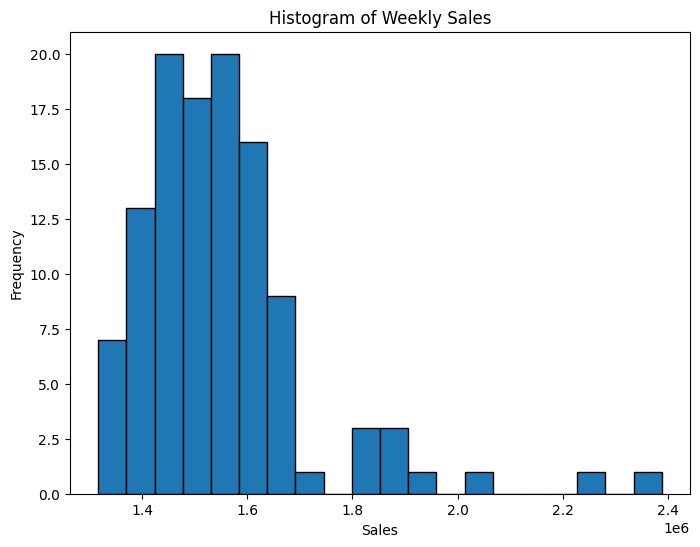

In [19]:
plt.figure(figsize=(8, 6))
plt.hist(train_data['Weekly_Sales'], bins=20, edgecolor='black')
plt.title(f'Histogram of Weekly Sales')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

As we can see, the distribution is right-skewed, so we could benefit from a Box-Cox Transformation and a normalization to make the data more Gaussian. We find the best value of lambda using Shapiro-Wilk tests.

Best lambda: -2.0


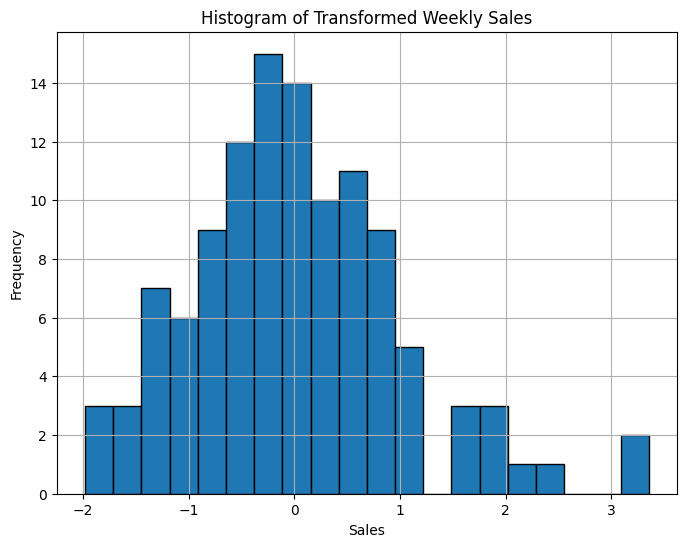

In [20]:
from scipy import stats
import numpy as np

lambda_values = np.linspace(-2, 2, num=41)  
shapiro_results = []

for lmbda in lambda_values:
    # Apply the Box-Cox transformation
    transformed_data = stats.boxcox(train_data['Weekly_Sales'], lmbda=lmbda)
    # Shapiro-Wilk test
    shapiro_stat, shapiro_p = stats.shapiro(transformed_data)
    shapiro_results.append((shapiro_stat, shapiro_p, lmbda))

best_result = max(shapiro_results, key=lambda x: x[1])
best_lambda = best_result[2]

print(f"Best lambda: {best_lambda}")

transformed_sales = stats.boxcox(train_data['Weekly_Sales'], lmbda=best_lambda)

mean_sales = transformed_sales.mean()
std_sales = transformed_sales.std()
norm_sales = (transformed_sales - mean_sales) / std_sales

sales_data = pd.DataFrame({'Transformed_Normalized_Sales': norm_sales, 'Transformed_Sales': transformed_sales}, index=train_data.index)

plt.figure(figsize=(8, 6))
plt.hist(norm_sales, bins=20, edgecolor='black')
plt.title('Histogram of Transformed Weekly Sales')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


We re-apply statistical decomposition to the transformed series.

(array([14610., 14700., 14791., 14883., 14975., 15065., 15156., 15248.,
        15340., 15431.]),
 [Text(14610.0, 0, '2010-01'),
  Text(14700.0, 0, '2010-04'),
  Text(14791.0, 0, '2010-07'),
  Text(14883.0, 0, '2010-10'),
  Text(14975.0, 0, '2011-01'),
  Text(15065.0, 0, '2011-04'),
  Text(15156.0, 0, '2011-07'),
  Text(15248.0, 0, '2011-10'),
  Text(15340.0, 0, '2012-01'),
  Text(15431.0, 0, '2012-04')])

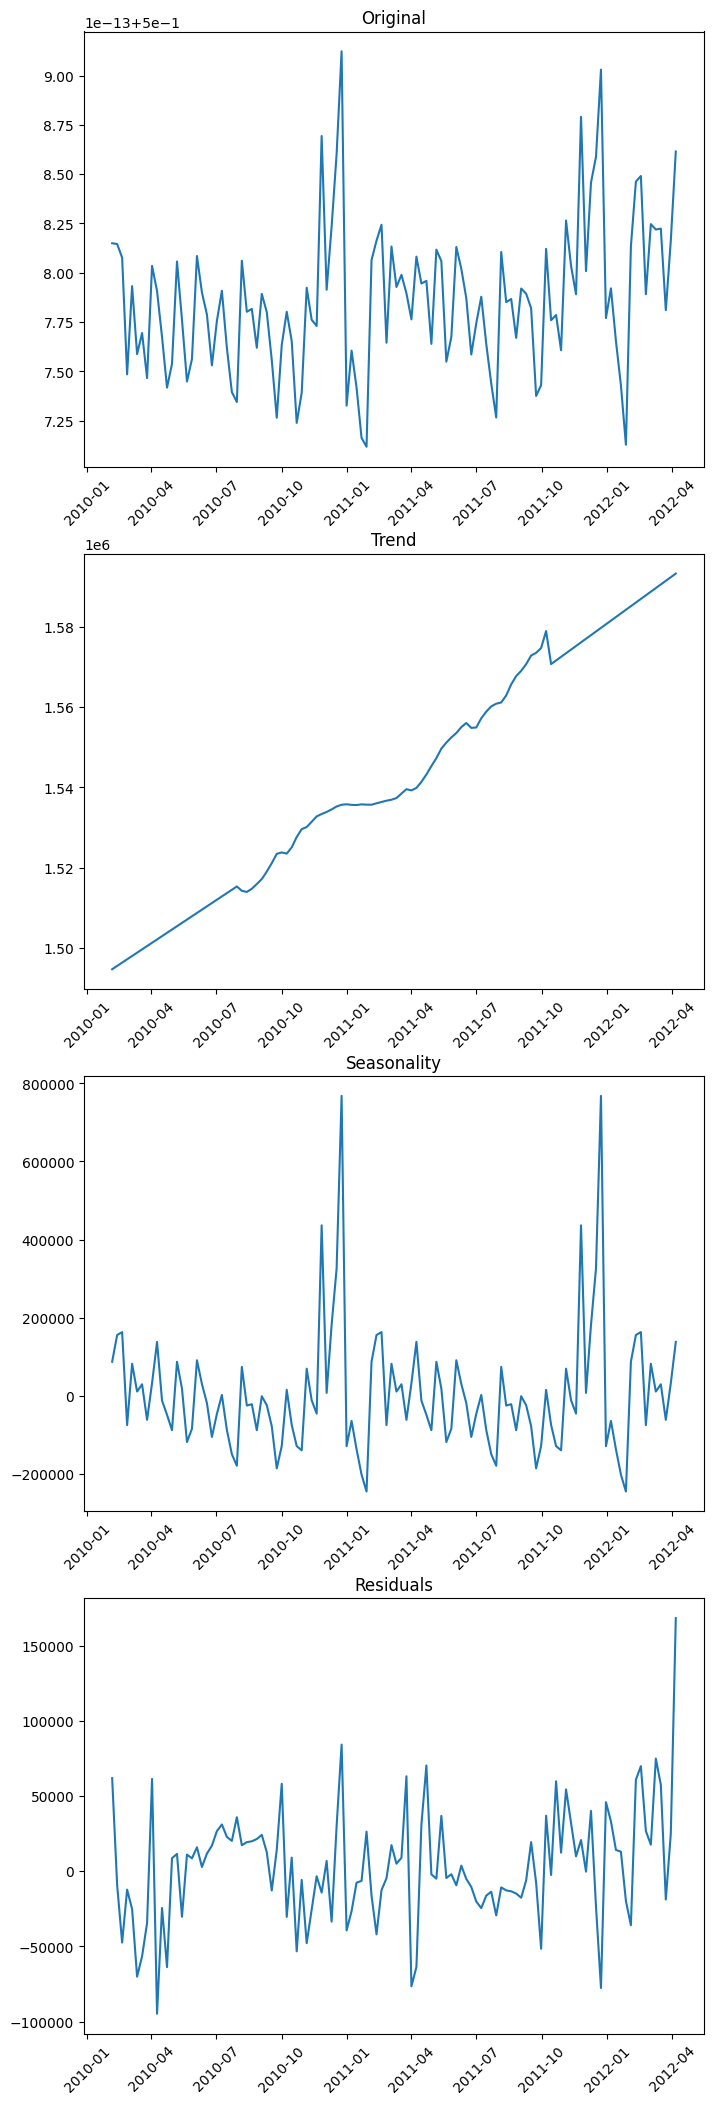

In [21]:
# Decompose the time series into trend, seasonality, and residual
decomposition = seasonal_decompose(sales_data['Transformed_Sales'], extrapolate_trend='freq', model='additive')
transformed_trend = decomposition.trend
transformed_seasonal = decomposition.seasonal
transformed_residual = decomposition.resid

plt.figure(figsize=(8, 26))
plt.subplot(411)
plt.plot(sales_data['Transformed_Sales'], label='Original')
plt.title('Original')
plt.xticks(rotation=45)

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.title('Trend')
plt.xticks(rotation=45)

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.title('Seasonality')
plt.xticks(rotation=45)

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.title('Residuals')
plt.xticks(rotation=45)

As we can see, there is still a trend and seasonality after the Box-Cox Transformation.

2. Differencing orders d, D identification

We first check for stationarity using Augmented Dickey-Fuller test

In [22]:
from statsmodels.tsa.stattools import adfuller

stationarity_results = adfuller(sales_data['Transformed_Sales'])
print('ADF Statistic: %f' % stationarity_results[0])
print('p-value: %f' % stationarity_results[1])
print('Critical Values:')
for key, value in stationarity_results[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.704086
p-value: 0.000083
Critical Values:
	1%: -3.492
	5%: -2.888
	10%: -2.581


d = 0, D = 0

3. Identifying p, q, P, Q

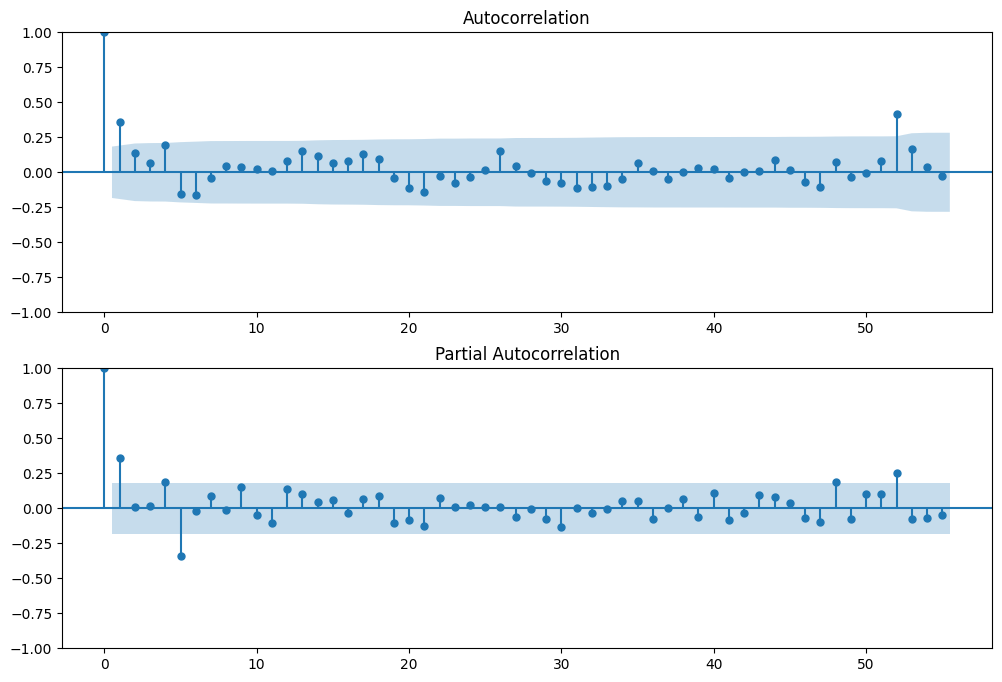

In [23]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Plot ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))
sm.graphics.tsa.plot_acf(sales_data['Transformed_Sales'], lags=55, ax=ax1)
sm.graphics.tsa.plot_pacf(sales_data['Transformed_Sales'], lags=55, ax=ax2)
plt.show()

p = 1, q = 1, P = 1, Q = 1

4. Analyzing eXogenous variables

Text(0, 0.5, 'Unemployment')

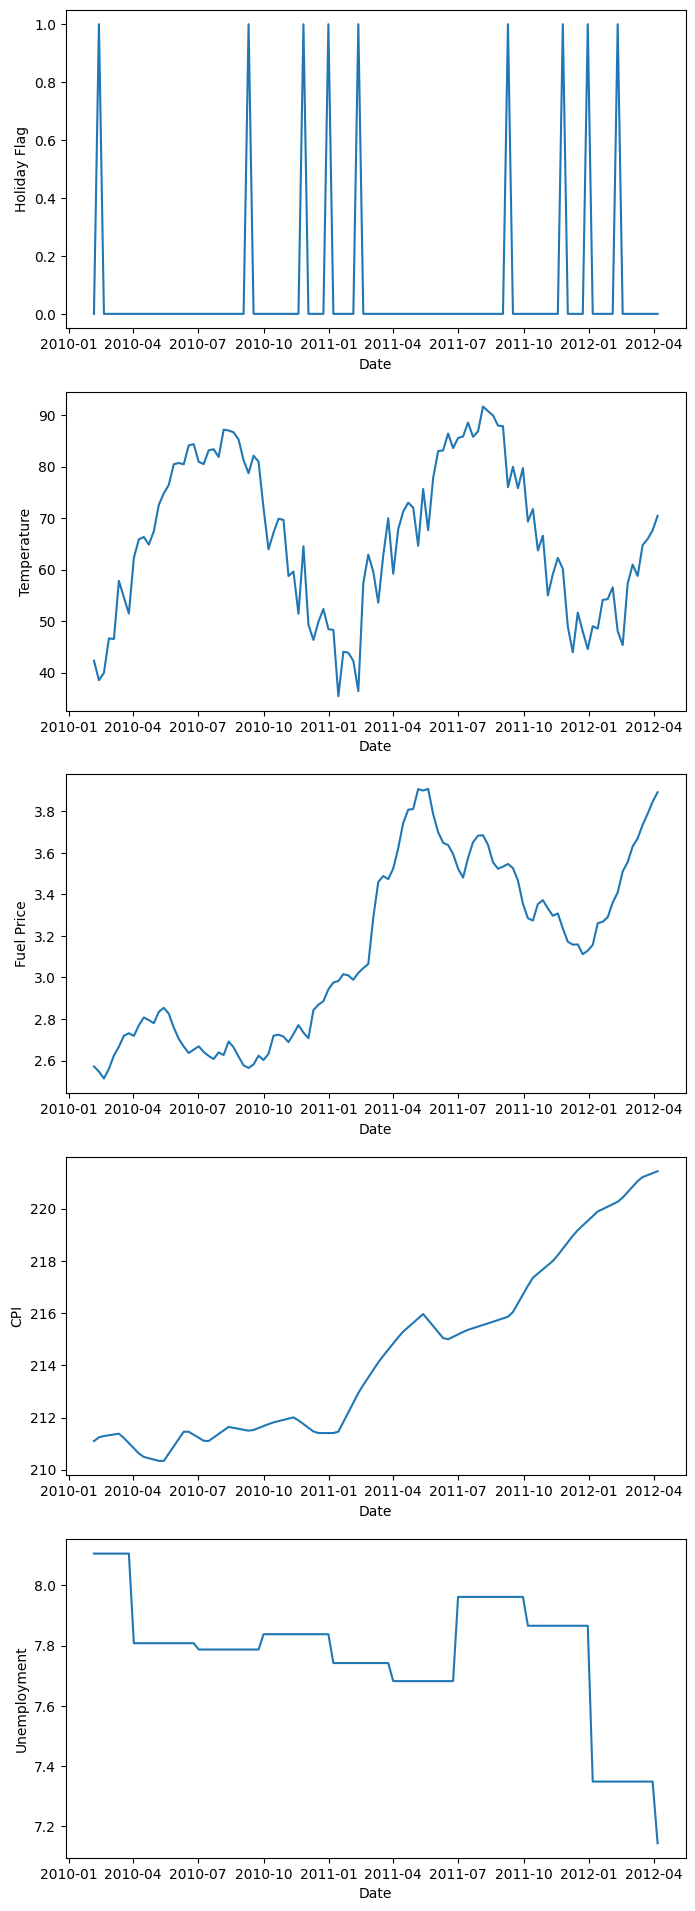

In [24]:
plt.figure(figsize=(8, 24))
plt.subplot(511)
plt.plot(train_data['Holiday_Flag'])
plt.xlabel('Date')
plt.ylabel('Holiday Flag')

plt.subplot(512)
plt.plot(train_data['Temperature'])
plt.xlabel('Date')
plt.ylabel('Temperature')

plt.subplot(513)
plt.plot(train_data['Fuel_Price'])
plt.xlabel('Date')
plt.ylabel('Fuel Price')

plt.subplot(514)
plt.plot(train_data['CPI'])
plt.xlabel('Date')
plt.ylabel('CPI')

plt.subplot(515)
plt.plot(train_data['Unemployment'])
plt.xlabel('Date')
plt.ylabel('Unemployment')

Only holiday flag and temperature seem to be seasonal.

5. Normalize variables

In [25]:
mean_temp = train_data['Temperature'].mean()
std_temp = train_data['Temperature'].std()
normalized_temp = (train_data['Temperature'] - mean_temp) / std_temp

mean_fuel = train_data['Fuel_Price'].mean()
std_fuel = train_data['Fuel_Price'].std()
normalized_fuel = (train_data['Fuel_Price'] - mean_fuel) / std_fuel

mean_cpi = train_data['CPI'].mean()
std_cpi = train_data['CPI'].std()
normalized_cpi = (train_data['CPI'] - mean_cpi) / std_cpi

mean_unem = train_data['Unemployment'].mean()
std_unem = train_data['Unemployment'].std()
normalized_unem = (train_data['Unemployment'] - mean_unem) / std_unem 

6. Implement Gradient Descent to solve problem

In [26]:
def compute_e(theta, data):
    n = len(data['Sales'])
    e = np.zeros(n)
    w = data['Sales']
    w_hat = np.zeros(n - 53)
    x1 = data['Holiday']
    x2 = data['Temp']
    x3 = data['Fuel']
    x4 = data['CPI']
    x5 = data['Unem']
    for t in range(53, n):
        f = [w[t-1], w[t-52], w[t-53], e[t-1], e[t-52], e[t-53], x1[t-1], x1[t-52], x1[t-53], x2[t-1], x2[t-52], x2[t-53], x3[t-1], x4[t-1], x5[t-1]]
        w_hat[t-53] = np.dot(theta, f)
        e[t-53] = w[t-53] - w_hat[t-53] 
    return e, f

def compute_gradient(e, data, f, num_param):
    grad = np.zeros(num_param)
    for t in range(53, len(data['Sales'])):
        grad = grad - np.full((num_param,), 2*e[t])*(f)
    return grad

def gradient_descent(data, theta_init, tolerance, max_iterations):
    theta = theta_init
    for i in range(max_iterations):
        alpha = 0.01
        e, f = compute_e(theta, data)
        gradient = compute_gradient(e, data, f, len(theta))
        theta -= alpha * gradient
        
        if np.linalg.norm(gradient) < tolerance:
            break
    return theta, e

C:\Users\inigo\AppData\Local\Temp\ipykernel_2976\3312794022.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f = [w[t-1], w[t-52], w[t-53], e[t-1], e[t-52], e[t-53], x1[t-1], x1[t-52], x1[t-53], x2[t-1], x2[t-52], x2[t-53], x3[t-1], x4[t-1], x5[t-1]]
C:\Users\inigo\AppData\Local\Temp\ipykernel_2976\3312794022.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  e[t-53] = w[t-53] - w_hat[t-53]


MSE:  0.03475745879652089
[ 0.02004385  0.01461762 -0.00653363  0.          0.          0.
  0.          0.          0.          0.00216317  0.00254653 -0.01190451
  0.04154431  0.05123333 -0.05399965]


C:\Users\inigo\AppData\Local\Temp\ipykernel_2976\2471141549.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_data['Holiday_Flag'][t-1], train_data['Holiday_Flag'][t-52], train_data['Holiday_Flag'][t-53],
C:\Users\inigo\AppData\Local\Temp\ipykernel_2976\2471141549.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  normalized_temp[t-1], normalized_temp[t-52], normalized_temp[t-53],
C:\Users\inigo\AppData\Local\Temp\ipykernel_2976\2471141549.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with Da

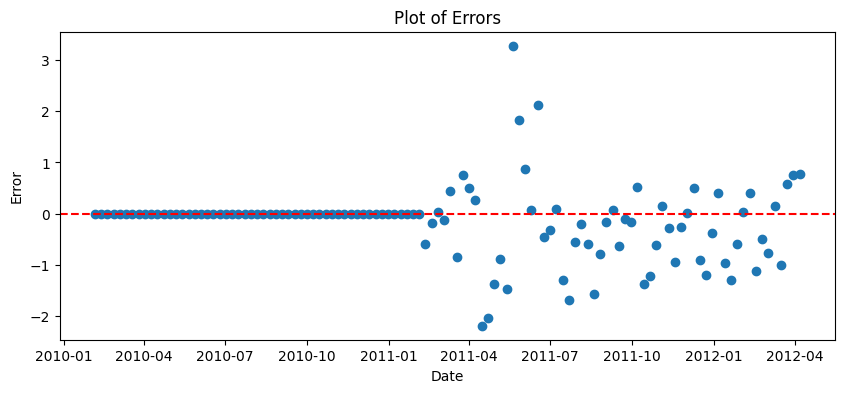

In [27]:
theta_init = np.zeros(15)


threshold = 1e-6  

max_iterations = 1000

data = {'Sales': sales_data['Transformed_Normalized_Sales'], 'Holiday': train_data['Holiday_Flag'], 'Temp': normalized_temp,
        'Fuel': normalized_fuel, 'CPI': normalized_cpi, 'Unem': normalized_unem}

optimized_theta, error = gradient_descent(data, theta_init, threshold, max_iterations)


sq_error = np.sum(np.square(error[53:])) / (len(error) - 53)

print("MSE: ", sq_error)

print(optimized_theta)

w_hat = np.zeros(len(error)-53)


for t in range(53, len(error)):
    w_hat[t-53] = np.dot(optimized_theta, [norm_sales[t-1], norm_sales[t-52], norm_sales[t-53], error[t-1], error[t-52], error[t-53],
              train_data['Holiday_Flag'][t-1], train_data['Holiday_Flag'][t-52], train_data['Holiday_Flag'][t-53],
                normalized_temp[t-1], normalized_temp[t-52], normalized_temp[t-53],
                normalized_fuel[t-1], normalized_cpi[t-1], normalized_unem[t-1]])
    

    
# Plot errors
plt.figure(figsize=(10, 4))
plt.plot(train_data.index, error[::-1], marker='o', linestyle='')
plt.title('Plot of Errors')
plt.xlabel('Date')
plt.ylabel('Error')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()


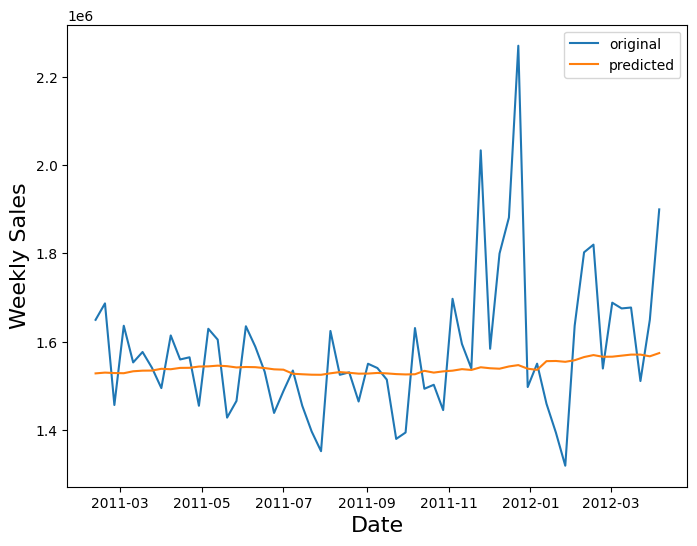

In [28]:
from scipy.special import inv_boxcox

# Denormalize

w_hat = w_hat*std_sales + mean_sales

# Revert Box-Cox transformation

y_hat = inv_boxcox(w_hat, best_lambda)


plt.figure(figsize=(8, 6))
plt.plot(train_data.index[53:], train_data['Weekly_Sales'][53:], label='original')
plt.plot(train_data.index[53:], y_hat, label='predicted')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Weekly Sales', fontsize=16)
plt.legend()
plt.show()


7. Test phase

Apply Box-Cox Transformation to test sales data

In [29]:
transformed_test_sales = stats.boxcox(test_data['Weekly_Sales'], lmbda=best_lambda)

mean_sales_test = transformed_test_sales.mean()
std_sales_test = transformed_test_sales.std()
norm_sales_test = (transformed_test_sales - mean_sales_test) / std_sales_test

Normalize test eXogenous variables

In [30]:
mean_temp_test = test_data['Temperature'].mean()
std_temp_test = test_data['Temperature'].std()
normalized_temp_test = (test_data['Temperature'] - mean_temp_test) / std_temp_test

mean_fuel_test = test_data['Fuel_Price'].mean()
std_fuel_test = test_data['Fuel_Price'].std()
normalized_fuel_test = (test_data['Fuel_Price'] - mean_fuel_test) / std_fuel_test

mean_cpi_test = test_data['CPI'].mean()
std_cpi_test = test_data['CPI'].std()
normalized_cpi_test = (test_data['CPI'] - mean_cpi_test) / std_cpi_test

mean_unem_test = test_data['Unemployment'].mean()
std_unem_test = test_data['Unemployment'].std()
normalized_unem_test = (test_data['Unemployment'] - mean_unem_test) / std_unem_test

Test dataset

C:\Users\inigo\AppData\Local\Temp\ipykernel_2976\622736171.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f = [w_train[t-1], w_train[t-52], w_train[t-53], e_train[t-1], e_train[t-52], e_train[t-53],
C:\Users\inigo\AppData\Local\Temp\ipykernel_2976\622736171.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1_train[t-1], x1_train[t-52], x1_train[t-53], x2_train[t-1], x2_train[t-52], x2_train[t-53],
C:\Users\inigo\AppData\Local\Temp\ipykernel_2976\622736171.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (con

[ 0.27877668 -0.57243914 -1.31094782  1.42806813  0.57325999  0.44498236
 -0.06927893  0.79438996  1.58999093  0.87420023 -0.37715311 -0.18492069
  2.3372106  -0.45846177 -0.81999978 -1.74237334  0.85575157  0.36997891
  0.42120809 -0.98479299  0.20155025  1.09091115 -0.74825162 -0.86048763
 -1.95771106  1.14304795 -0.12973441 -0.99865352 -1.19518375]
MSE 1.0449949112130912


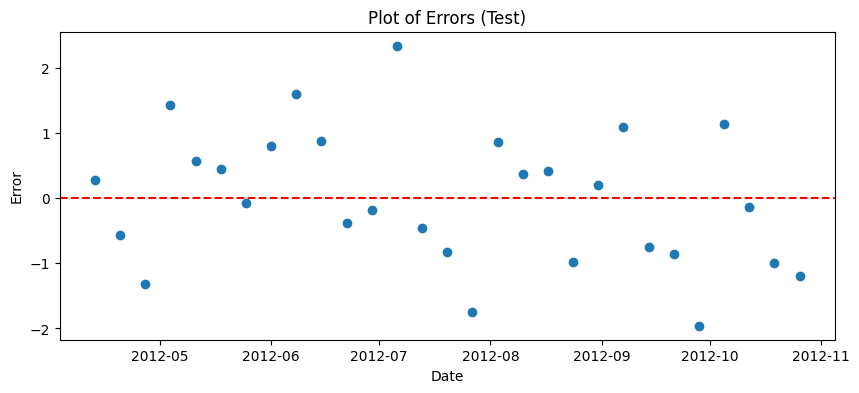

In [32]:
w_test = norm_sales_test
w_hat_test = np.zeros(len(norm_sales_test))
e_test = np.zeros(len(norm_sales_test))
x1_test = test_data['Holiday_Flag']
x2_test = normalized_temp_test
x3_test = normalized_fuel_test
x4_test = normalized_cpi_test
x5_test = normalized_unem_test

w_train = sales_data['Transformed_Normalized_Sales'][-53:]
e_train = error[-53:]
x1_train = train_data['Holiday_Flag'][-53:]
x2_train = normalized_temp[-53:]
x3_train = normalized_fuel[-53:]
x4_train = normalized_cpi[-53:]
x5_train = normalized_unem[-53:]

for t in range(len(norm_sales_test)):
    if t == 0:
        f = [w_train[t-1], w_train[t-52], w_train[t-53], e_train[t-1], e_train[t-52], e_train[t-53],
              x1_train[t-1], x1_train[t-52], x1_train[t-53], x2_train[t-1], x2_train[t-52], x2_train[t-53],
                x3_train[t-1], x4_train[t-1], x5_train[t-1]]
    elif t < 52:
        f = [w_test[t-1], w_train[t-52], w_train[t-53], e_test[t-1], e_train[t-52], e_train[t-53],
              x1_test[t-1], x1_train[t-52], x1_train[t-53], x2_test[t-1], x2_train[t-52], x2_train[t-53],
                x3_test[t-1], x4_test[t-1], x5_test[t-1]]
    elif t < 53:
        f = [w_test[t-1], w_test[t-52], w_train[t-53], e_test[t-1], e_test[t-52], e_train[t-53],
              x1_test[t-1], x1_test[t-52], x1_train[t-53], x2_test[t-1], x2_test[t-52], x2_train[t-53],
                x3_test[t-1], x4_test[t-1], x5_test[t-1]]
    else:
        f = [w_test[t-1], w_test[t-52], w_test[t-53], e_test[t-1], e_test[t-52], e_test[t-53],
              x1_test[t-1], x1_test[t-52], x1_test[t-53], x2_test[t-1], x2_test[t-52], x2_test[t-53],
                x3_test[t-1], x4_test[t-1], x5_test[t-1]]
    w_hat_test[t] = np.dot(optimized_theta, f)
    e_test[t] = w_test[t] - w_hat_test[t]

print(e_test)

sq_error_test = np.sum(np.square(e_test)) / (len(e_test))

print("MSE", sq_error_test)

# Plot errors
plt.figure(figsize=(10, 4))
plt.plot(test_data.index, e_test, marker='o', linestyle='')
plt.title('Plot of Errors (Test)')
plt.xlabel('Date')
plt.ylabel('Error')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

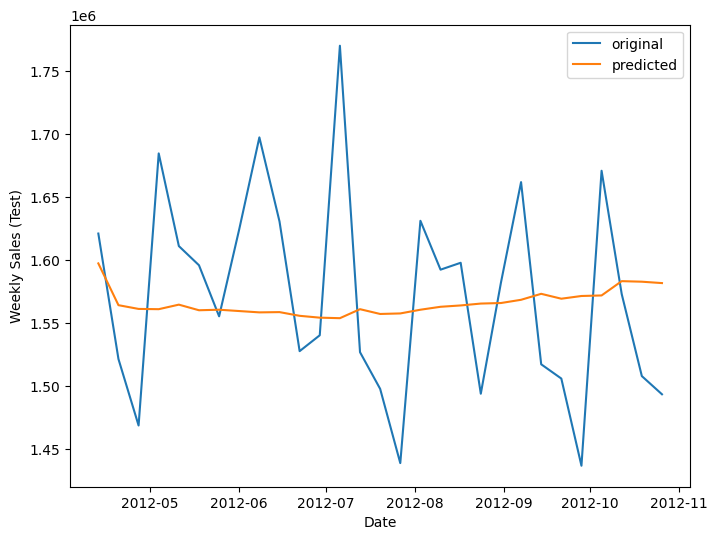

In [33]:
from scipy.special import inv_boxcox

y_prima_hat_test = std_sales_test*w_hat_test + mean_sales_test
y_hat_test = inv_boxcox(y_prima_hat_test, best_lambda)

y_hat_test_series = pd.Series(y_hat_test, index=test_data.index)

plt.figure(figsize=(8, 6))
plt.plot(test_data['Weekly_Sales'], label='original')
plt.plot(y_hat_test_series, label='predicted')
plt.xlabel('Date')
plt.ylabel('Weekly Sales (Test)')
plt.legend()
plt.show()
